## Intro to Gaussian processes

source: Gaussian processes for Machine Learning, C.Rasmussen et. al

In [323]:
# Importations

import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

plt.rcParams['figure.figsize'] = (10.0, 10.0)

### Bayesian linear regression

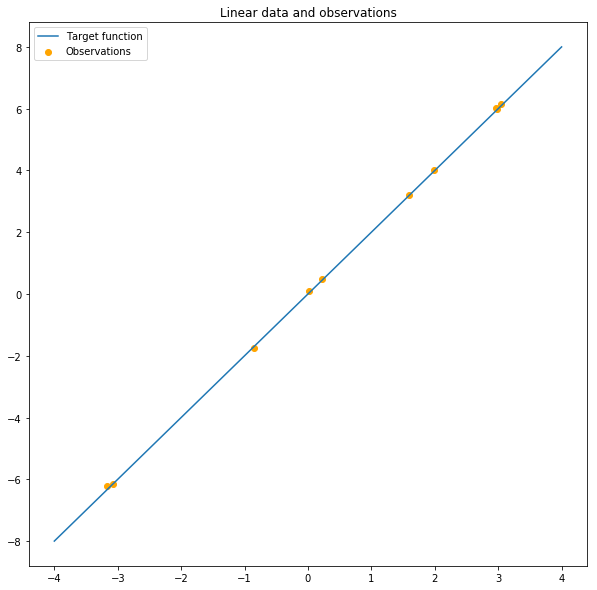

In [324]:
def generate_linear_observations(slope=2, offset=0, n_obs=10, noise_amount=0.1, 
                                 xlim=[-4,4],
                                 display=True,
                                 show=True):

    x=np.linspace(xlim[0], xlim[1])

    y=slope * x + offset

    # make noisy observations 
    x_obs=xlim[0] + (xlim[1] - xlim[0]) * np.random.uniform(size=n_obs)
    y_obs=slope * x_obs + offset + noise_amount * np.random.normal(size=n_obs)


    if(display):
        plt.plot(x,y, label="Target function")
        plt.scatter(x_obs, y_obs, color='orange', label="Observations")
        plt.legend()
        plt.title("Linear data and observations")
        if(show):
            plt.show()
    return x_obs, y_obs

x_obs, y_obs = generate_linear_observations()

We want to fit the data to a linear model with isotropic normal additive noise:
$$ y_i = x_i^Tw + \sigma_i \forall i=1...n$$

We assume a gaussian prior on the parameter $w$: $$w \sim \mathcal{N}(O, \Sigma_p)$$

Text(0.5,1,'Prior over w')

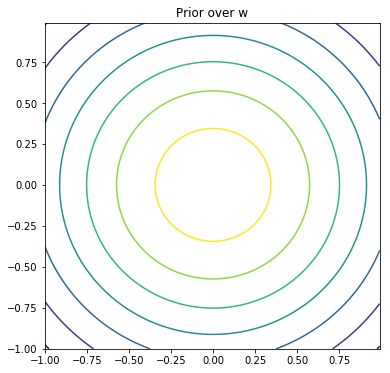

In [325]:
def plot_gaussian(mean=np.array([0,0]),
                  sigma=np.array([[1,0],
                                  [0,1]])):

    x, y = np.mgrid[-1:1:.01, -1:1:.01]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    # multivariate_normal loops over the first two coordinates of pos and applies the density 
    # to element at index i,j 
    plt.contour(x, y, multivariate_normal.pdf(pos, mean=mean, cov=sigma))
    
plt.figure(figsize=(6,6))
plot_gaussian()
plt.title("Prior over w")


We plot for each parameter $w=(w_1, w_2)$ on the grid the likelihood of the observations under these parameters:
$$p(y_i|x_i,w)=\frac{1}{\sqrt{(2\pi \sigma^2}} exp(-\frac{(yi - w^Txi)^2}{2})$$

so $$ p(y|x,w)=\prod_{i=1}^n \frac{1}{\sqrt{(2\pi \sigma^2}} exp(-\frac{(y_i - w^Tx_i)^2}{2})$$

Text(0.5,1,'likelihoods of the regression parameters w, as a function of w')

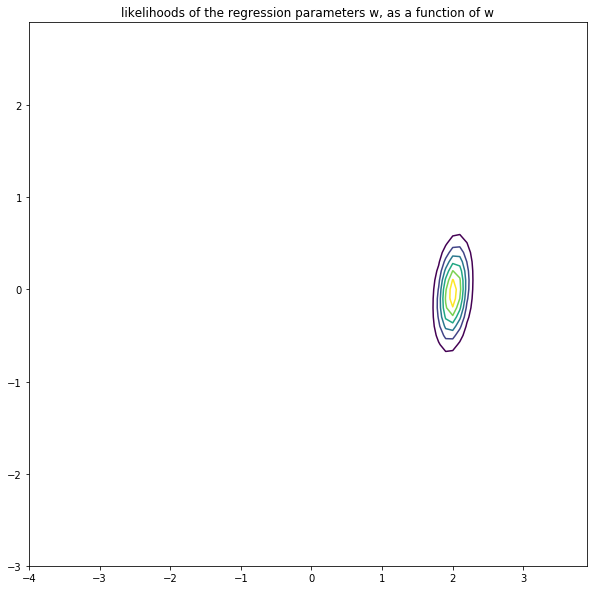

In [326]:
def likelihood(w0, w1, x,y):
    """
    likelihood of the observations x,y
    """
    n = x.shape[0]
    tmp = (y - (x * w0) + w1)

    p = (1. / np.sqrt((2 * np.pi) ** n)) * np.exp(-0.5 * tmp.T.dot(tmp))
    return p
           

def plot_likelihood(x_obs, y_obs,
                    xlim=[-5,5],
                    ylim=[-5,5],
                    step=0.1):
    w1, w2 = np.mgrid[xlim[0]:xlim[1]:step, ylim[0]:ylim[1]:step]
    grid_size = w1.shape
    pos = np.empty(w1.shape + (2,))
    pos[:, :, 0] = w1; pos[:, :, 1] = w2
    z = np.zeros((grid_size))
    for i in range(pos.shape[0]):
        for j in range(pos.shape[1]):
            z[i,j] = likelihood(pos[i,j,0], pos[i,j,1], x_obs, y_obs)
    
    plt.contour(w1, w2, z)
    
plot_likelihood(x_obs, y_obs, [-4,4], [-3,3])
plt.title("likelihoods of the regression parameters w, as a function of w")

The posterior distribution can be expressed as 
$$p(w|x,y) \sim \mathcal{N}(\bar{w}, A^{-1})$$

where $$\bar{w}=\frac{1}{\sigma^2} A^{-1}Xy$$ and $$ A=\frac{XX^T}{\sigma^2} + \Sigma^{-1}$$.

$\sigma$ is the standard deviation of the noise in the model, and $\Sigma_p$ is the covariance matrix of the prior over the parameters

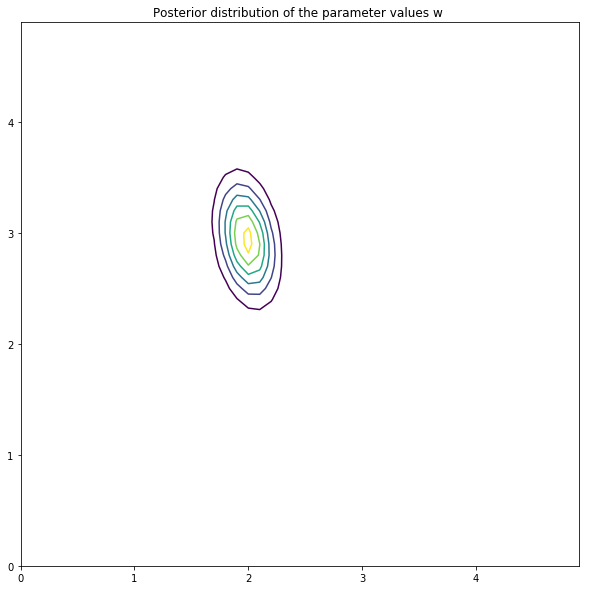

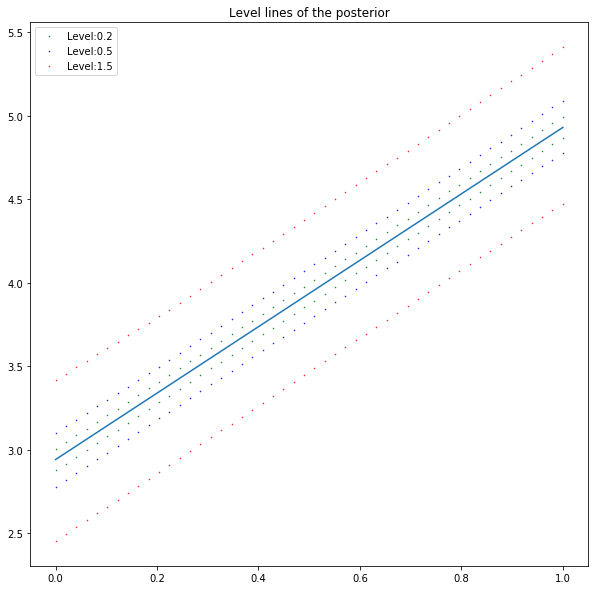

In [327]:

import numpy as np

#linear regression
class BayesianLinearRegression(object):
    """
    Class for bayesian linear regression
    """

    def __init__(self):
        self.mean = None # mean of the posterior distribution
        self.cov = None #Covariance of the posterior distribution
        self.w = None
        self.b = None

    def fit(self, X_tr, y_tr):
        """
        Trains the bayesian linear model using MAP. We suppose that the noise of the model has variance 1]
        and that the prior is a centered and reduced gaussian.
        Parameters:
        ===========
        X_tr: d*n design matrix
        y_tr: n*1 target vector
        """
        
        if(len(X_tr.shape)<2):
            X_tr = X_tr[:, np.newaxis] 
            
        p, n = np.shape(X_tr)

        M = X_tr @ X_tr.T + 0.1*np.identity(p)
        
        b = X_tr @ y_tr

        self.cov = np.linalg.pinv(M)
        w_aug = self.cov @ b

        self.w = w_aug[0:p-1]
        self.b = w_aug[p-1]
        self.mean = w_aug
        
        return self.w, self.b

    def get_params(self):
        return self.w, self.b

    def predict_regressor(self, X_t):
        """
        Predicts the ouput of the linear function given the input X_t
        """
        return X_t.dot((self.w).T) + self.b
    def predict(self, X_t, treshold = 0.5):
        """
        Predicts the binary class of X based on treshold
        """
        return (X_t.dot((self.w).T) + self.b > treshold).astype(int)
    
    
    def plot_posterior(self,
                   xlim=[0,5],
                   ylim=[0,5],
                   step=0.1,
                   lam=0):
        """
        Parameters:
        ==========
            X: d*n design matrix (n columns where n is the nb of observations)
            y: n -dimensional scalar output vector
        Returns:
        ========
            The posterior probability of w
        """
        plt.figure(figsize=(10,10))

        w1, w2 = np.mgrid[xlim[0]:xlim[1]:step, ylim[0]:ylim[1]:step]

        grid_size = w1.shape

        pos = np.empty(w1.shape + (2,))

        pos[:, :, 0] = w1; pos[:, :, 1] = w2

        plt.contour(w1, w2, multivariate_normal.pdf(pos, mean=self.mean, cov=self.cov))
        plt.title("Posterior distribution of the parameter values w ")
        plt.show()
        return self.mean
    def get_bounds(self, n_samples, n_units=1):
        """
        Get parameters samples that have n_units unit malanahony distance from the mean 
        """
        theta = 2*np.pi*np.linspace(0,1, n_samples)
        unit_circle = np.c_[np.cos(theta), np.sin(theta)]
        L = np.linalg.cholesky(blr.cov)
        return self.mean + n_units * unit_circle @ L.T
        
    def plot_unit_bounds(self, n_samples=10,
                        levels = [0.2, 0.5, 1.5]):
        """
        Plot lines for the parameters that are one times the standard deviation away from the mean
        """
        
        
        fig, ax = plt.subplots(figsize=(10,10))
        x = np.linspace(0,1)
        w=self.mean
        plt.plot(x, w[0] * x + w[1])

        colors=['g', 'b', 'r']
        for i, l in enumerate(levels):
            samples = self.get_bounds(n_samples, n_units=l)
            lower_bound = np.min([x * sample[0] +  sample[1] for sample in samples], axis=0)
            upper_bound = np.max([x * sample[0] +  sample[1] for sample in samples], axis=0)
            bounds = ["lower","upper"]
            for j,line in enumerate([lower_bound, upper_bound]):
                ax.plot(x, line, '.', markersize=1, 
                            color=colors[i],
                            label="Level:{}".format(levels[i]) if (j==0) else None)

        ax.legend()
        plt.title("Level lines of the posterior")

        

blr = BayesianLinearRegression()
n_samples=10
X,y=generate_linear_observations(n_obs=n_samples, 
                                 slope=2,
                                 offset=3,
                                 noise_amount=0.1, display=False)
plt.show()

X_tr = np.c_[X, np.ones(n_samples)].T
y_tr=y
w, b = blr.fit(X_tr, y_tr)
blr.plot_posterior()
blr.plot_unit_bounds()

## Gaussian process regression

If we assume the model $y = f(x)$ where $f(x)=\phi(x)^Tw$ follows a gaussain process $\mathcal{GP}(0, k(x,x'))$

$$
\begin{pmatrix} 
y_1  \\
y_2 
\end{pmatrix}  
\sim \mathcal{N}(
    \begin{pmatrix} 
    0  \\
    0 
    \end{pmatrix} ,
    \begin{pmatrix} 
    \Sigma_{11}, \Sigma_{12}  \\
    \Sigma_{21}, \Sigma_{22}
    \end{pmatrix})$$
    
The conditional distribution of $y_2$ given $x_1, y_1, x_2$ can be written as 

$$ (y_2|x_1, y_1, x_2) \sim 
\mathcal{N}(\mu_{2|1}, \Sigma_{2|1})$$

with $$
\begin{align}
\mu_{2|1} & = \mu_2 - \Sigma_{21}\Sigma_{11}^{-1} y_1 \\
          & =- \Sigma_{21}\Sigma_{11}^{-1} y_1
\end{align}$$

and $\Sigma_{2|1}=\Sigma_{22} - \Sigma_{21}\Sigma_{11}^{-1}\Sigma_{12}$


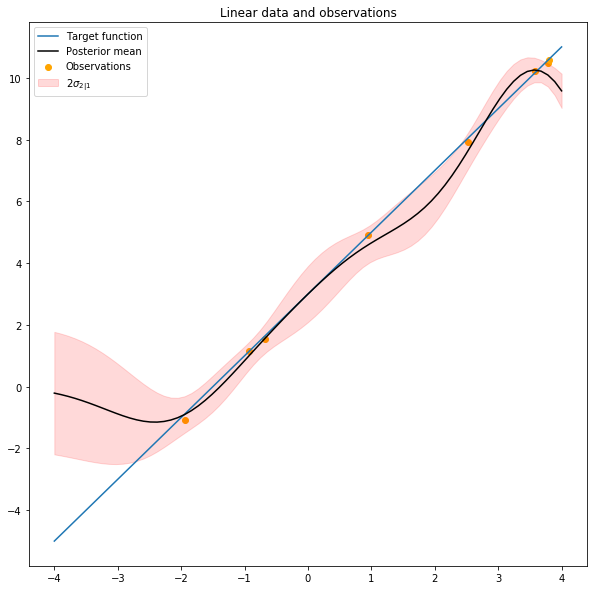

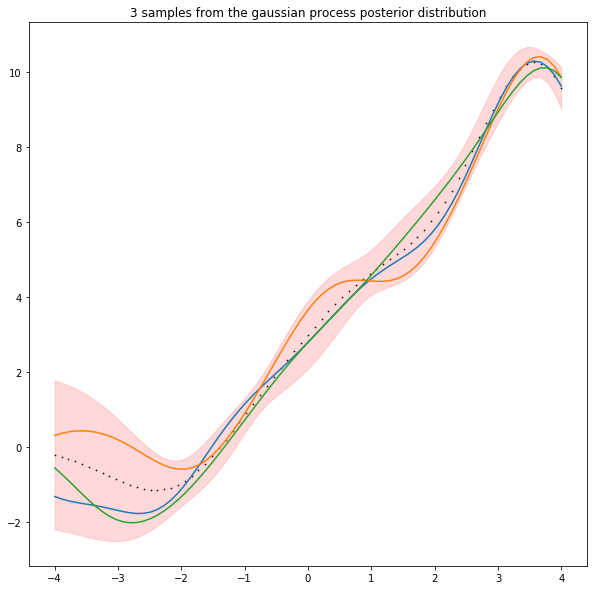

In [337]:
from scipy.linalg import solve,cholesky

class Kernel(object):
    @staticmethod
    def euclidian(self, x1, x2):
        return sp.spatial.distance.cdist(x1, x2, 'sqeuclidean')
    @staticmethod
    def rbf(x1, x2, sigma=1):
        """Radial basis kernel with standard deviation sigma"""
        # L2 distance (Squared Euclidian)
        if(len(x1.shape) != 2):
            x1 = x1[:, np.newaxis]
        if(len(x2.shape) != 2):
            x2 = x2[:, np.newaxis]
            
        sq_norm = -0.5 * sp.spatial.distance.cdist(x1, x2, 'sqeuclidean') / sigma ** 2
        return np.exp(sq_norm)

class GaussianProcessRegression(object):
    """
    Class for Gaussian process regression
    """

    def __init__(self, kernel=Kernel.rbf):
        self.mean = None # mean of the posterior distribution
        self.cov = None #Covariance of the posterior distribution
        self.w = None
        self.b = None
        self.xlim = [-4, 4]
        self.test_size = None
        self.kernel = kernel
        
    def get_posterior(self, 
                      X_tr,
                      y_tr,
                      X_te,
                      kernel=Kernel.rbf,
                      sigma_n=0.1, 
                      display=True):
        """
        Return the mean and covariance of the posterior distribution of the output y_te,
        computed using the training data X_tr, y_tr and the test observations X_te
        Parameters
        ----------
        X_tr: n1*d array of training samples
        y_tr: n1*1 array of training target values
        X_te: n2*d array of testing samples
        Returns
        -------
        mu_posterior: mean of the posterior gaussian distribution
        sigma_posterior: covariance of the posterior distribution
        """
        # preprocessing
        if(len(X_tr.shape) != 2):
            X_tr = X_tr[:, np.newaxis]
        if(len(X_te.shape) != 2):
            X_te = X_te[:, np.newaxis]
        
        # Set the number n2 of test samples 
        self.test_size = X_te.shape[0]
        
        mu1 = 0
        mu2 = 0
        sigma11 = kernel(X_tr, X_tr) + sigma_n * np.eye(X_tr.shape[0])
        sigma22 = kernel(X_te, X_te)
        sigma12 = kernel(X_tr, X_te)
        
        solved = solve(sigma11, sigma12, assume_a='pos').T
        mu_posterior = solved @ y_tr
        sigma_posterior = sigma22 - solved @ sigma12
        
        self.mean = mu_posterior
        self.cov = sigma_posterior
        if(display):
            sigma2 = np.sqrt(np.diag(self.cov))
            plt.plot(X_te.flat, self.mean, 'black', label="Posterior mean")
            plt.fill_between(X_te.flat,
                             self.mean-2*sigma2,
                             self.mean+2*sigma2,
                             color='red', 
                 alpha=0.15, label='$2 \sigma_{2|1}$')
                
        return mu_posterior, sigma_posterior
    
    def sample_level(self, level=1, test_size=None):
        """
        Sample from the posterior distribution on the level line defined by points that are
        at a distance 'level' * std from the mean 
        """
        if(self.test_size is None):
            test_size = self.mean.shape[0]
        else:
            theta = 2*np.pi*np.linspace(0,1, test_size)
            unit_circle = np.c_[np.cos(theta), np.sin(theta)]
            return self.mean + level * unit_circle @ blr.cov
        
    def generate_prior_samples(self,
                               n_samples=5,
                               xlim=[-4, 4],
                               n_points=50, display=True):
        """
        Generate samples from a prior distribution
        """
        X = np.linspace(xlim[0], xlim[1], n_points)
        sigma = Kernel.rbf(X, X)

        ys = np.random.multivariate_normal(
            mean=np.zeros(n_points), cov=sigma, 
            size=n_samples)
        if(display):
            colors = plt.cm.viridis.colors
            step = len(colors) // ys.shape[0]
            for i, y in enumerate(ys):
                plt.plot(X, y, color=colors[i * step], alpha=0.5)
            plt.title("{} samples from a gaussian process prior distribution".format(n_samples))
            plt.show()
    
        return X, ys


    
    def plot_posterior(self,
                       X_tr,
                       y_tr,
                       mean=None,
                       cov=None, n_samples=3, xlim=[-4, 4], display=True):
        """
        Generate samples from the posterior distributions
        """
            
        n_points = self.mean.shape[0]
        X = np.linspace(xlim[0], xlim[1], n_points)
        
        ys =  np.random.multivariate_normal(mean = self.mean, cov=self.cov, 
            size=n_samples)
        sigma2 = np.sqrt(np.diag(self.cov))
        
        if(display):
            plt.scatter(X, self.mean, color='b', s=0.5)
            plt.fill_between(X.flat,
                             self.mean-2*sigma2,
                             self.mean+2*sigma2,
                             color='red', 
                 alpha=0.15, label='$2 \sigma_{2|1}$')
            plt.title("{} samples from the gaussian process posterior distribution".format(n_samples))

        return X, ys

    def generate_samples(self,
                         mean=None,
                         cov=None,
                         n_samples=3,
                         xlim=[-4, 4],
                         display=True):
        """
        Generate samples from the posterior distributions
        """
            
        n_points = self.mean.shape[0]
        X = np.linspace(xlim[0], xlim[1], n_points)
        
        ys =  np.random.multivariate_normal(mean = self.mean, cov=self.cov, 
            size=n_samples)
        sigma2 = np.sqrt(np.diag(self.cov))
        
        if(display):
            plt.plot(X, ys.T)
            plt.scatter(X, self.mean, color='black', s=0.5, label="Posterior mean")
            plt.fill_between(X.flat,
                             self.mean-2*sigma2,
                             self.mean+2*sigma2,
                             color='red', 
                 alpha=0.15, label='$2 \sigma_{2|1}$')
            plt.title("{} samples from the gaussian process posterior distribution".format(n_samples))

        return X, ys


plt.figure(figsize=(10,10))

trainsize, testsize = 8, 75
X_tr, y_tr = generate_linear_observations(n_obs=trainsize, 
                                         slope=2,
                                         offset=3,
                                         noise_amount=0.1,
                                         show=False)

X_te = np.linspace(-4, 4, testsize)

gpr = GaussianProcessRegression()

mean, cov = gpr.get_posterior(X_tr[:, np.newaxis], y_tr, X_te, display=True)
plt.legend()
plt.show()
X, y = gpr.generate_samples(mean, cov)
plt.show()

